# 임베딩 내 편향성 알아보기 [프로젝트]

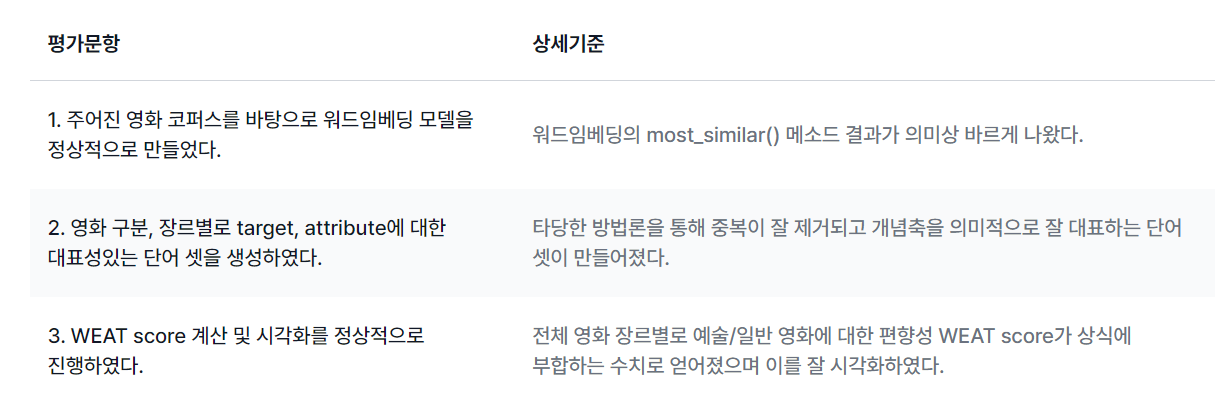

### 워드 임베딩을 시놉시스 기반으로 진행
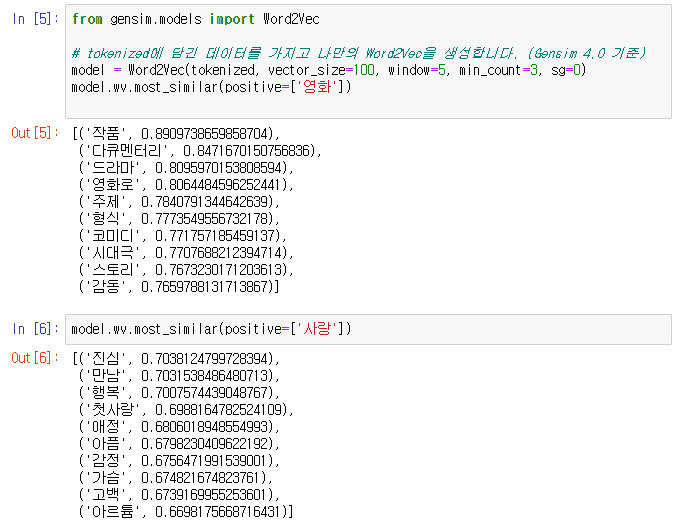

# 각 장르별 TF-idf 사용 + 중복제거X

- 장르중 비교했을때 멜로 로맨스가 예술영화인 경우가 많다는 편향이있다.
- 가장 점수가 높은건 미스터리와 범죄였는데
- 미스터리쪽으로가면 예술, 그리고 범죄는 일반영화라는 편견이 강한듯하다

- 반대로 장르중 일반측 편향이 가장 많은 장르는 다큐멘터리
- 가장 높은 점수는 범죄와 스릴러였다.
- 범죄는 비슷한 장르와 붙었을때 일반장르라는 편향이 강하다


## WEAK 점수가 0.8이상인 조합(예술, 일반)
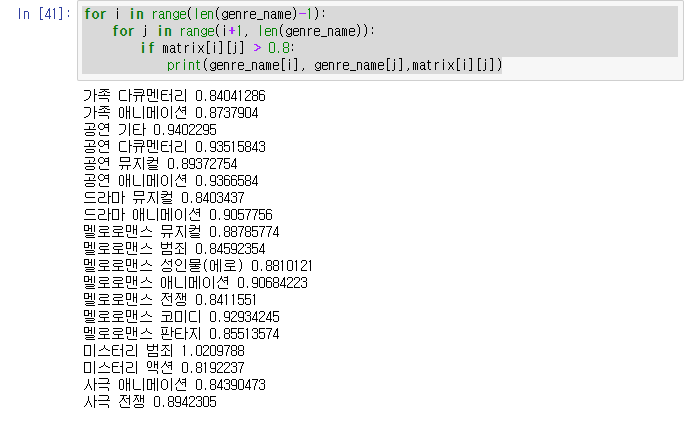

## WEAK 점수가 - 0.8이하인 조합(일반, 예술)
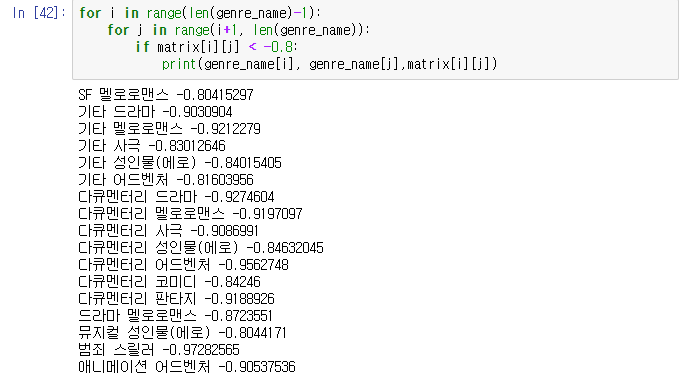

## heat map 분석
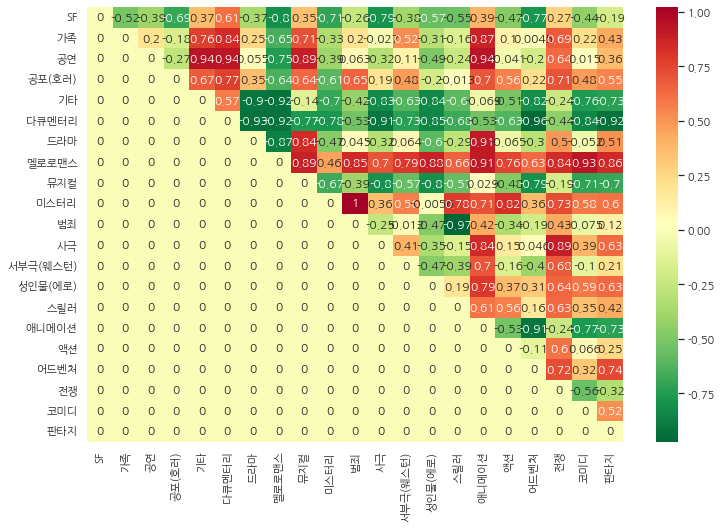


# 각 장르별 단어 분석
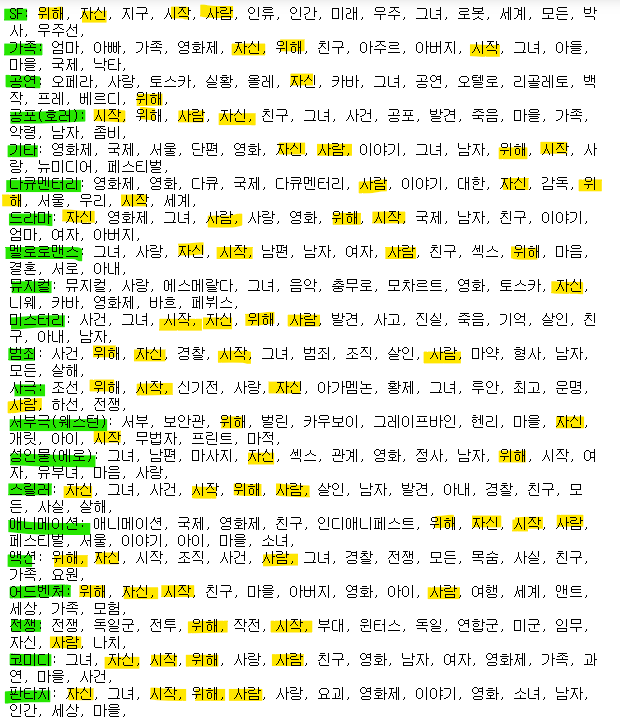

- 사람, 위해, 영화, 자신, 시작, 남자, 여자, 그녀 같은 단어가 중복되서 나온다
- 일단 수작업으로 제거해보자

## 작업 후
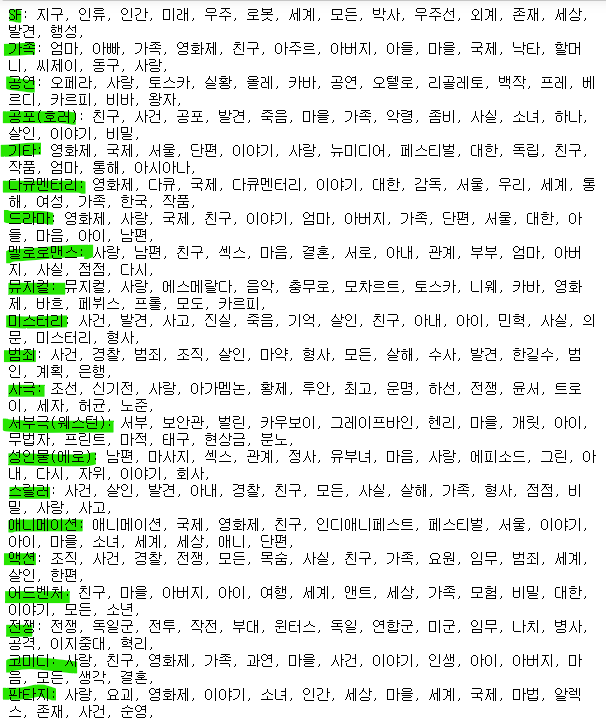
- 확실히 중복이 제거되고 각 장르별 특정단어를 많이 포함한다


# 중복 제거후 결과 분석

## WEAK 점수가 0.8이상인 조합(예술, 일반) 편향이 강함
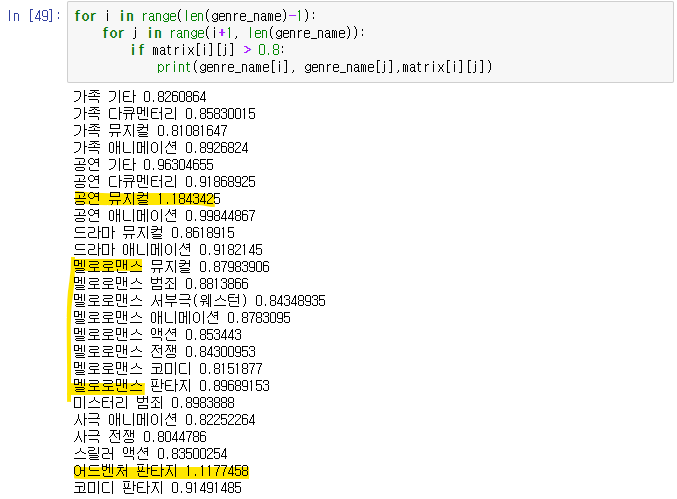

## WEAK 점수가 -0.8이하인 조합(일반, 예술) 편향이 강함
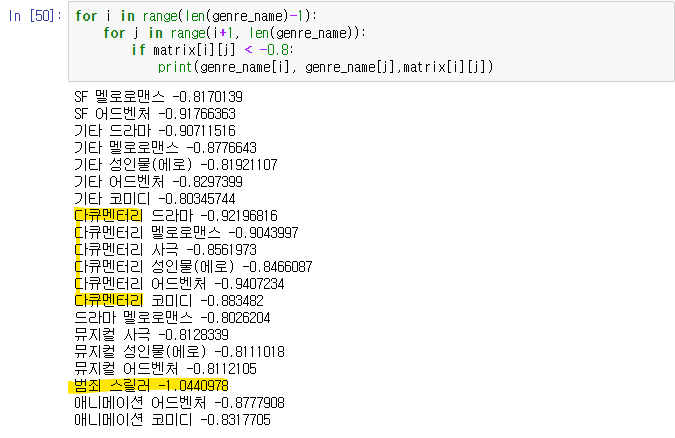


# 회고
- 영화 시놉시스로 학습한 임베딩 벡터내에 예술과 일반영화를 구별하는 편향이 존재한다는것을 발견하고 그 정도를 측정하는 방법에 대해서 배워봤다.
- 영빈 퍼실님의 말대로 중복을 제거하거나 넣어주는 데이터셋의 품질을 만드는것은 결국 수작업이 필요하겠구나 하고생각이 들었다. 모든것을 자동화 할수는 없겟구나
- 이 방식은 임베딩벡터의 편향성을 파악하는 용도로 사용되다보니 생각보다 활용성은 떨어질수있겠다는 생각이 들었다. 하지만 재미가있었다

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

import konlpy
import gensim
import sklearn
import seaborn

# 영화 시놉시스를 기반으로 워드 임베딩 모델 구축

In [ ]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

In [ ]:
# 시놉시스 전체를 읽고 명사만 뽑는 코드?
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [ ]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])


In [ ]:
model.wv.most_similar(positive=['사랑'])

# WEAT score 함수 구현

In [ ]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

# 각 장르별로 target, attribute 데이터 만들기
- 명사만 남기고 제거
- tf-idf를 사용해서 점수가 높은순으로 정렬
- 각자에게 없는 단어만을 15개 추출

In [ ]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [ ]:
art = read_token(art_txt)
gen = read_token(gen_txt)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])
print(X.shape)
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()
w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

In [ ]:
w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True) 

In [ ]:
w1[100][1]

In [ ]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

In [ ]:
# 중복단어 제거

n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']


genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

In [ ]:
print(X.shape)

In [ ]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

# 중복 제거

In [ ]:
for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes_redu = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:            
            if not vectorizer.get_feature_names()[w[i][j][0]] in ['사람', '위해', '시작', '자신', '영화', '남자', '여자', '그녀']:
                attr.append(vectorizer.get_feature_names()[w[i][j][0]])
                print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes_redu.append(attr)
    print()

In [ ]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

In [ ]:
attributes[1]

In [ ]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes_redu[i]])
        B = np.array([model.wv[word] for word in attributes_redu[j]])
        matrix[i][j] = weat_score(X, Y, A, B)


In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] < -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 8))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax